[DIY Covid-19 Dashboard Kit](https://github.com/fsmeraldi/diy-covid19dash) (C) Fabrizio Smeraldi, 2020 ([f.smeraldi@qmul.ac.uk](mailto:f.smeraldi@qmul.ac.uk) - [web](http://www.eecs.qmul.ac.uk/~fabri/)). All rights reserved.

# DIY Covid-19 Dashboard

The coronavirus pandemic is currently affecting the whole world, causing an overwhelming amount of infections and deaths on a daily basis. This dashboard focuses on data for England. It maps out the hospital cases, new admissions and ventilator bed occupanacy over time. In addition it maps out new cases with hospital admissions. 

# Key for Graphs within Dashboard


- Hospital Cases refers to hospital cases 
- New Admissions refers to new admissions at hospital
- Ventilator Bed Occupancy refers to COVID-19 occupied beds with mechanical ventilators
- New Cases refers to new cases by publish date


Please press the refresh button to refresh the data for the latest view of the graph

In [1]:
import ipywidgets as wdg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from uk_covid19 import Cov19API

In [2]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [3]:
# Load JSON files and store the raw data in some variable. Edit as appropriate
#jsondata={}
with open("england.json", "rt") as INFILE:
    data1=json.load(INFILE)



In [8]:
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

def wrangle_data(data):
    datalist=data['data']
    dates=[dictionary['date'] for dictionary in datalist ]
    dates.sort()
    
    startdate=parse_date(dates[0])
    enddate=parse_date(dates[-1])
    index=pd.date_range(startdate, enddate, freq='D')
    
    england_df=pd.DataFrame(index=index, columns=['covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions'])
    for entry in datalist: # each entry is a dictionary with date, cases, hospital and deaths
        date=parse_date(entry['date'])
        for column in ['covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions']:
        # check that nothing is there yet - just in case some dates are duplicated,
        # maybe with data for different columns in each entry
        #print(england_df.loc[date, column])
         if pd.isna(england_df.loc[date, column]): 
            # replace None with 0 in our data 
            value= float(entry[column]) if entry[column]!=None else 0.0
            # this is the way you access a specific location in the dataframe - use .loc
            # and put index,column in a single set of [ ]
            england_df.loc[date, column]=value
            
            
            
# fill in any remaining "holes" due to missing dates
    england_df.fillna(0.0, inplace=True)
    return england_df
            


 


    
england_df=wrangle_data(data1)
#england_df.to_pickle("england_df.pkl")
#area_df.to_pickle("area_df.pkl")
#england_df.plot()
#england_df.head()
#for col in england_df.columns:
    #england_df[col].values[:] = 1

In [9]:
def access_api():
    filters= [
        'areaType=nation',
        'areaName=england'
    ]


# values here are the names of the PHE metrics
    structure = {
       "date": "date",
       "covidOccupiedMVBeds":"covidOccupiedMVBeds",
       "hospitalCases": "hospitalCases",
       "newAdmissions": "newAdmissions"    
    }
    
    api = Cov19API(filters=filters, structure=structure)
    england=api.get_json()
    print(england)
    #with open("england.json", "wt") as OUTF:
        #json.dump(england, OUTF)
    #with open("england.json", "rt") as INFILE:
        #data=json.load(INFILE)
    #INFLIE.close()
    
    return england

#access_api()

    


## New Admissions, Hospital Cases and Ventilator Bed Occupancy per day in England

In [26]:
def api_button_callback(button):
    apidata=access_api()
    global england_df
    england_df=wrangle_data(apidata)
    refresh_graph()
    apibutton.icon="check"
    
apibutton=wdg.Button(
    description='Refresh data', # you may want to change this...
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to download current Public Health England data',
    # FontAwesome names without the `fa-` prefix - try "download"
    icon='download'
)

# remember to register your button callback function with the button
apibutton.on_click(api_button_callback) # the name of your function inside these brackets

display(apibutton)

Button(button_style='success', description='Refresh data', icon='download', style=ButtonStyle(), tooltip='Clic…

In [27]:
#england_df=pd.read_pickle("england_df.pkl")

def england_graph(gcols, gscale):
    #print(gcols)
    #print(gscale)
    #print(england_df)
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        england_df[list(gcols)].plot(logy=logscale)
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")
        
series1=wdg.SelectMultiple(
    options=['covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions'],
    value=['covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions'],
    rows=3,
    description='Stats:',
    disabled=False
)
    
scale1=wdg.RadioButtons(
    options=['linear', 'log'],
    #value='pineapple', # Defaults to 'pineapple'
    #layout={'width': 'max-content'}, # If the items' names are long
    description='Scale:',
    disabled=False
)

controls=wdg.HBox([series1, scale1])


def refresh_graph():
    """ We change the value of the widget in order to force a redraw of the graph;
    this is useful when the data have been updated. This is a bit of a gimmick; it
    needs to be customised for one of your widgets. """
    current=scale1.value
    if current==scale1.options[0]:
        other=scale1.options[1]
    else:
        other=scale1.options[0]
    scale1.value=other # forces the redraw
    scale1.value=current # now we can change it back
    
# keep calling timeseries_graph(gcols=value_of_series, gscale=value_of_scale); capture output in variable graph   
graph1=wdg.interactive_output(england_graph, {'gcols': series1, 'gscale': scale1})

#display(controls, graph)
# stack series and scale on top of each other
ctrls1=wdg.VBox([series1, scale1])
# put the graph and the controls side by side
form=wdg.HBox([graph1, ctrls1])

# Now form contains the entire interface
display(form)

## Ventilator Bed Occupancy per day in England - Graph

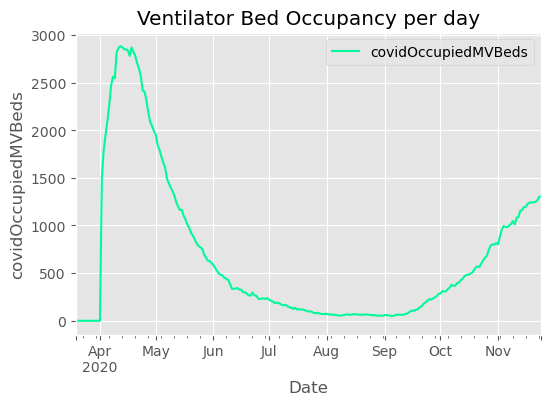

In [48]:
def draw_1():
    subplot = england_df.plot(y='covidOccupiedMVBeds', color = 'mediumspringgreen')
    plt.style.use("ggplot")
    plt.xlabel("Date")
    plt.ylabel("covidOccupiedMVBeds")
    plt.title("Ventilator Bed Occupancy per day")
    plt.grid(True)


def change_1():
    plt.clf()

draw_1()



## Hospital Cases per day in England - Graph

In [ ]:
england_df.plot(y='hospitalCases', color = 'deeppink')
plt.style.use("ggplot")
plt.xlabel("Date")
plt.ylabel("Hospital Cases")
plt.title("Hospital Cases per day")
plt.grid(True)

## New Admissions per day in England - Graph

In [ ]:
england_df.plot(y='newAdmissions', color = 'mediumslateblue')
plt.style.use("ggplot")
plt.xlabel("Date")
plt.ylabel("New Admissions")
plt.title("New Admissions per day")
plt.grid(True)

In [12]:
INFILE.close()

In [13]:
with open("area.json", "rt") as INFILE:
    data2=json.load(INFILE)

In [22]:
def parse2_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

def wrangle2_data(data):
    datalist=data2['data']
    dates=[dictionary['date'] for dictionary in datalist ]
    dates.sort()
    
    startdate=parse2_date(dates[0])
    enddate=parse2_date(dates[-1])
    index=pd.date_range(startdate, enddate, freq='D')
    
    area_df=pd.DataFrame(index=index, columns=['newCases', 'hospitalAdmissions'])
    for entry in datalist: # each entry is a dictionary with date, cases, hospital and deaths
        date=parse2_date(entry['date'])
        for column in ['newCases', 'hospitalAdmissions']:
        # check that nothing is there yet - just in case some dates are duplicated,
        # maybe with data for different columns in each entry
        #print(england_df.loc[date, column])
         if pd.isna(area_df.loc[date, column]): 
            # replace None with 0 in our data 
            value= float(entry[column]) if entry[column]!=None else 0.0
            # this is the way you access a specific location in the dataframe - use .loc
            # and put index,column in a single set of [ ]
            area_df.loc[date, column]=value
            
            
            
# fill in any remaining "holes" due to missing dates
    area_df.fillna(0.0, inplace=True)
    #print(area_df)
    return area_df
            


 


    
area_df=wrangle2_data(data2)
#area_df.to_pickle("area_df.pkl")
#area_df=pd.read_pickle("area_df.pkl")
#england_df.plot()
#england_df.head()

In [23]:
def access2_api():
    filters= [
        'areaType=nation',
        'areaName=england'
    ]


# values here are the names of the PHE metrics
    structure = {
       "date":"date",
       "newCases":"newCasesByPublishDate",
       "hospitalAdmissions": "newAdmissions"  
    }
    
    api_two = Cov19API(filters=filters, structure=structure)
    area=api_two.get_json()
    #print(area)
    #with open("england.json", "wt") as OUTF:
        #json.dump(england, OUTF)
    #with open("england.json", "rt") as INFILE:
        #data=json.load(INFILE)
    #INFLIE.close()
    
    return area
#access_api()

## New Cases and Hospital Admissions per day in England 

In [20]:
def api_button2_callback(button):
    apidata_two=access2_api()
    global area_df
    area_df=wrangle2_data(apidata_two)
    refresh2_graph()
    apibutton_two.icon="check"
    #graph.plt.style.use("ggplot")
   
    
apibutton_two=wdg.Button(
    description='Refresh data', # you may want to change this...
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to download current Public Health England data',
    # FontAwesome names without the `fa-` prefix - try "download"
    icon='download'
)

# remember to register your button callback function with the button
apibutton_two.on_click(api_button2_callback) # the name of your function inside these brackets

display(apibutton_two)

Button(button_style='success', description='Refresh data', icon='download', style=ButtonStyle(), tooltip='Clic…

In [24]:
#area_df=pd.read_pickle("area_df.pkl")


          
def area_graph(gcols, gscale):
    #print(gcols)
    #print(gscale)
    #print(england_df)
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        area_df[list(gcols)].plot(logy=logscale)
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")
        
series2=wdg.SelectMultiple(
    options=['newCases', 'hospitalAdmissions'],
    value=['newCases', 'hospitalAdmissions'],
    rows=2,
    description='Stats:',
    disabled=False
)
    
scale2=wdg.RadioButtons(
    options=['linear', 'log'],
    #value='pineapple', # Defaults to 'pineapple'
    #layout={'width': 'max-content'}, # If the items' names are long
    description='Scale:',
    disabled=False
)

controls=wdg.HBox([series2, scale2])


def refresh2_graph():
    """ We change the value of the widget in order to force a redraw of the graph;
    this is useful when the data have been updated. This is a bit of a gimmick; it
    needs to be customised for one of your widgets. """
    current_2=scale2.value
    if current_2==scale2.options[0]:
        other_2=scale2.options[1]
    else:
        other_2=scale2.options[0]
    scale2.value=other_2 # forces the redraw
    scale2.value=current_2 # now we can change it back
    
# keep calling timeseries_graph(gcols=value_of_series, gscale=value_of_scale); capture output in variable graph   
graph2=wdg.interactive_output(area_graph, {'gcols': series2, 'gscale': scale2})

#display(controls, graph)
# stack series and scale on top of each other
ctrls2=wdg.VBox([series2, scale2])
# put the graph and the controls side by side
form_2=wdg.HBox([graph2, ctrls2])

# Now form contains the entire interface
display(form_2)

## New Cases by Publish Date in England - Graph

In [ ]:
area_df.plot(y='newCases', color = 'red')
plt.style.use("ggplot")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.title("New Cases by Date")
#plt.grid(True)

## Hospital Admissions per day in England - Graph

In [ ]:
area_df.plot(y='hospitalAdmissions', color = 'purple')
plt.style.use("ggplot")
plt.xlabel("Date")
plt.ylabel("Hospital Admissions")
plt.title("Hospital Admissions by Date")
plt.grid(True)

## A Comparison Between Hospital Admissions and New Cases in England

In [ ]:
area_df.plot(kind = 'scatter', x= 'newCases', y='hospitalAdmissions', color = 'yellow')
plt.style.use("ggplot")
plt.xlabel("New Cases")
plt.ylabel("Hospital Admissions")
plt.title("Comparison of new Cases with Hospital Admissions")
plt.grid(True)

**Author and Copyright Notice**  (C) Jennifer Chidera Chukwumah, 2020 j.c.chukwumah@se20.qmul.ac.uk All rights reserved: *Based on UK Government [data](https://coronavirus.data.gov.uk/) published by [Public Health England](https://www.gov.uk/government/organisations/public-health-england).*